# Weather predictions with RNN

Dataset used : https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data/data

In [ ]:
# all needed imports
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense, BatchNormalization, Dropout
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping

In [ ]:
# This will prompt for authorization.
drive.mount('/content/drive')

!ls "/content/drive/My Drive/MLA_project/datasets"

Mounted at /content/drive
humidity.csv  pressure.csv  temperature.csv  wind_direction.csv  wind_speed.csv


# Data analysis and preparation

### Dataset description

We got our dataset from [here](https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data/data). Quoting from the source:

*The dataset contains ~5 years of high temporal resolution (hourly measurements) data of various weather attributes, such as temperature, humidity, air pressure, etc.*

*This data is available for 30 US and Canadian Cities, as well as 6 Israeli cities*

*Each attribute has it's own file and is organized such that the rows are the time axis (it's the same time axis for all files), and the columns are the different cities (it's the same city ordering for all files as well).*


---



Our files are:


*   **city_attributes.csv** - contains names of every city, country and coordinates
*   **pressure.csv** - air pressure in hPa
*   **weather_description.csv** - short description of the weather, ex. *sky is clear*
*   **wind_speed.csv** - in meters per second
*   **humidity.csv** - relative humidity of air
*   **temperature.csv** - self explainatory
*   **wind_direction.csv** - wind direction in degrees where 0 degrees corresponds to north, 90 - east, 180 - south and 270 - west.



## Temperature

In [ ]:
# an example of how data is stored in those files
df = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/temperature.csv")

df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


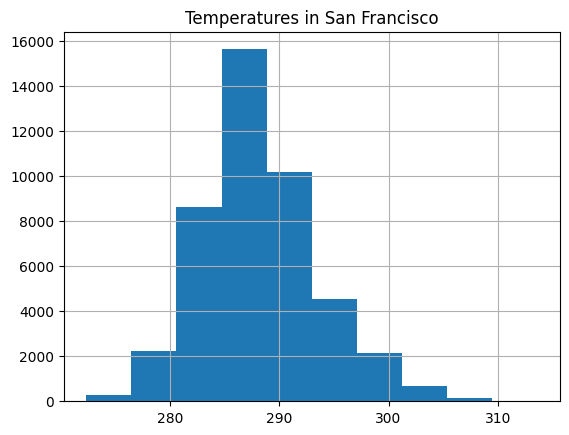

In [ ]:
cityname = 'San Francisco'
df = df.dropna()

df[cityname].hist()
plt.title(f'Temperatures in {cityname}')
plt.show()

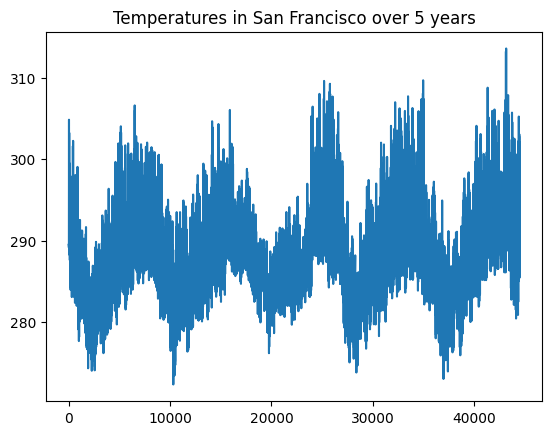

In [ ]:
plt.figure()
plt.plot(df[cityname])
plt.title(f'Temperatures in {cityname} over 5 years')
plt.show()

# one year = 8760 hours

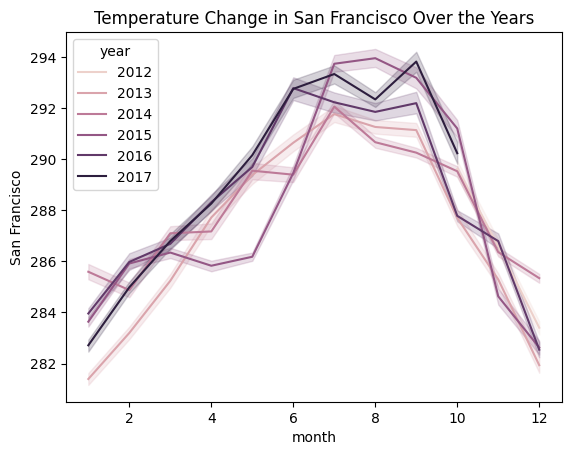

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")
df['year'] = df['datetime'].dt.year
df["month"] = df["datetime"].dt.month

#temperature comparison on each year
plt.title(f"Temperature Change in {cityname} Over the Years")
sns.lineplot(data = df, x='month', y='San Francisco', hue='year')
plt.show()

## Humidity

In [ ]:
#humidity data
df = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/humidity.csv")
df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2,2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
3,2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
4,2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0


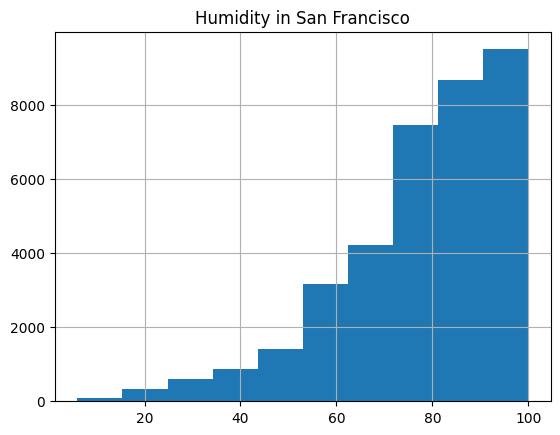

In [ ]:
cityname = 'San Francisco'
df = df.dropna()

df[cityname].hist(bins=10)
plt.title(f'Humidity in {cityname}')
plt.show()

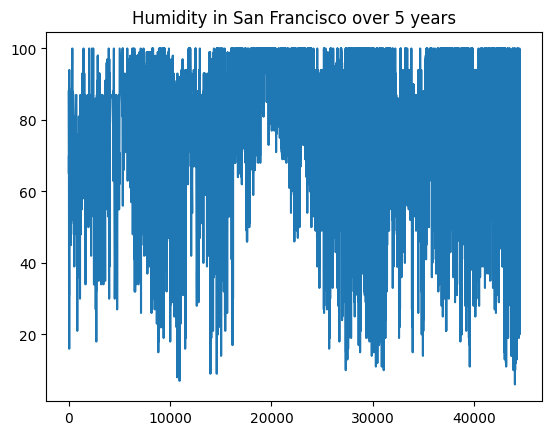

In [ ]:
plt.figure()
plt.plot(df[cityname])
plt.title(f'Humidity in {cityname} over 5 years')
plt.show()

# one year = 8760 hours

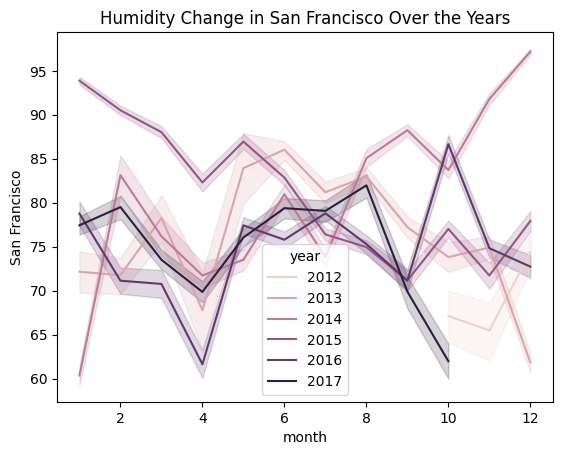

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")
df['year'] = df['datetime'].dt.year
df["month"] = df["datetime"].dt.month

#humidity comparison on each year
plt.title(f"Humidity Change in {cityname} Over the Years")
sns.lineplot(data = df, x='month', y='San Francisco', hue='year')
plt.show()

## Pressure

In [ ]:
#pressure data
df = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/pressure.csv")
df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1011.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2,2012-10-01 14:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
3,2012-10-01 15:00:00,NaN,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
4,2012-10-01 16:00:00,NaN,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


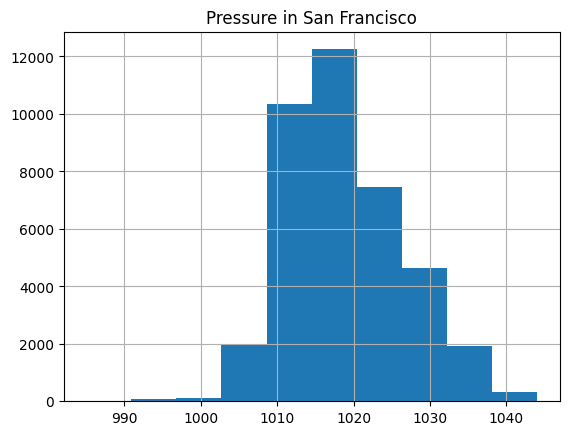

In [ ]:
cityname = 'San Francisco'
df = df.dropna()

df[cityname].hist()
plt.title(f'Pressure in {cityname}')
plt.show()

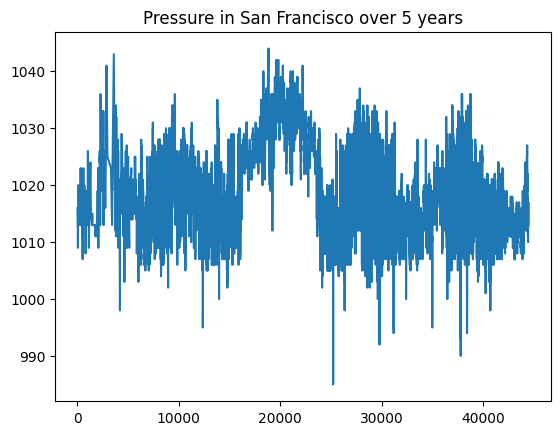

In [ ]:
plt.figure()
plt.plot(df[cityname])
plt.title(f'Pressure in {cityname} over 5 years')
plt.show()

# one year = 8760 hours

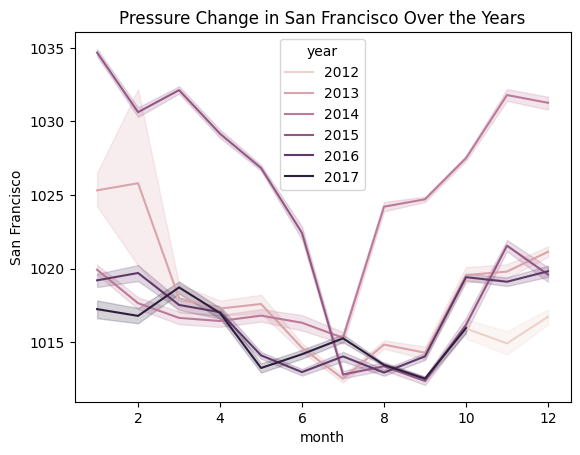

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")
df['year'] = df['datetime'].dt.year
df["month"] = df["datetime"].dt.month

#humidity comparison on each year
plt.title(f"Pressure Change in {cityname} Over the Years")
sns.lineplot(data = df, x='month', y='San Francisco', hue='year')
plt.show()

## Wind Speed

In [ ]:
#wind speed data
df = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/wind_speed.csv")
df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,...,4.0,7.0,4.0,3.0,1.0,0.0,8.0,2.0,2.0,2.0
2,2012-10-01 14:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,...,4.0,7.0,4.0,3.0,3.0,0.0,8.0,2.0,2.0,2.0
3,2012-10-01 15:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,...,3.0,7.0,4.0,3.0,3.0,0.0,8.0,2.0,2.0,2.0
4,2012-10-01 16:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,...,3.0,7.0,4.0,3.0,3.0,0.0,8.0,2.0,2.0,2.0


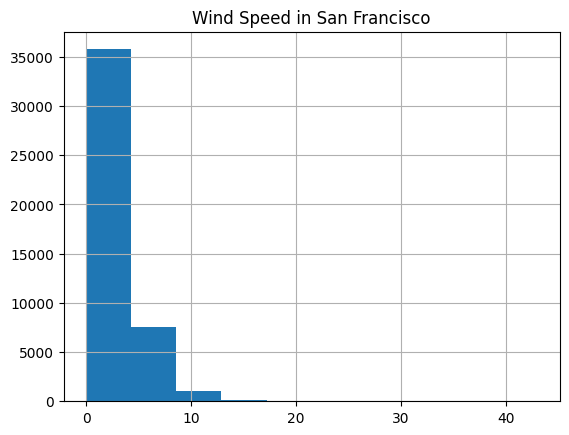

In [ ]:
cityname = 'San Francisco'
df = df.dropna()

df[cityname].hist()
plt.title(f'Wind Speed in {cityname}')
plt.show()

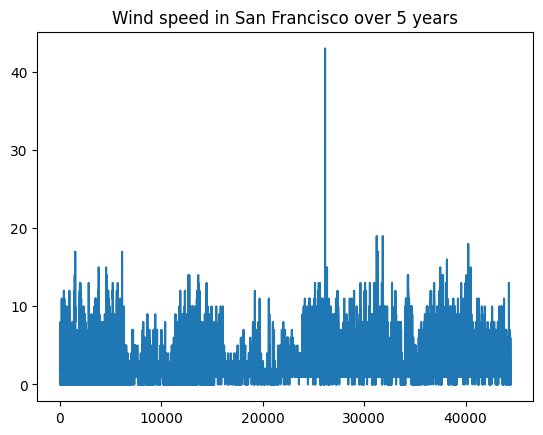

In [ ]:
plt.figure()
plt.plot(df[cityname])
plt.title(f"Wind speed in {cityname} over 5 years")
plt.show()

# one year = 8760 hours

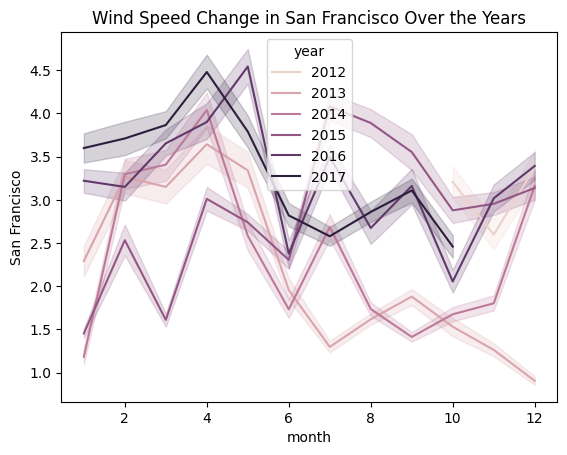

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")
df['year'] = df['datetime'].dt.year
df["month"] = df["datetime"].dt.month

#humidity comparison on each year
plt.title(f"Wind Speed Change in {cityname} Over the Years")
sns.lineplot(data = df, x='month', y='San Francisco', hue='year')
plt.show()

## Wind Direction

In [ ]:
#wind direction data
df = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/wind_direction.csv")
df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,360.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,0.0,0.0,150.0,0.0,0.0,0.0,0.0,10.0,360.0,...,270.0,260.0,230.0,60.0,135.0,101.0,30.0,336.0,336.0,329.0
2,2012-10-01 14:00:00,6.0,4.0,147.0,2.0,0.0,0.0,8.0,9.0,360.0,...,270.0,260.0,230.0,60.0,157.0,315.0,30.0,336.0,336.0,329.0
3,2012-10-01 15:00:00,20.0,18.0,141.0,10.0,0.0,0.0,23.0,9.0,360.0,...,271.0,260.0,231.0,60.0,157.0,307.0,30.0,336.0,336.0,329.0
4,2012-10-01 16:00:00,34.0,31.0,135.0,17.0,0.0,0.0,37.0,9.0,360.0,...,272.0,260.0,233.0,60.0,157.0,294.0,30.0,336.0,336.0,329.0


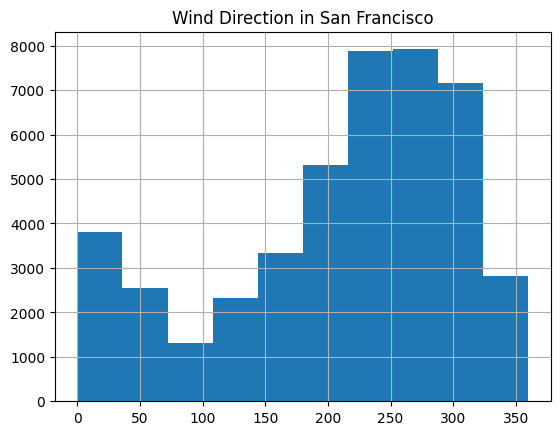

In [ ]:
cityname = 'San Francisco'
df = df.dropna()

df[cityname].hist()
plt.title(f'Wind Direction in {cityname}')
plt.show()

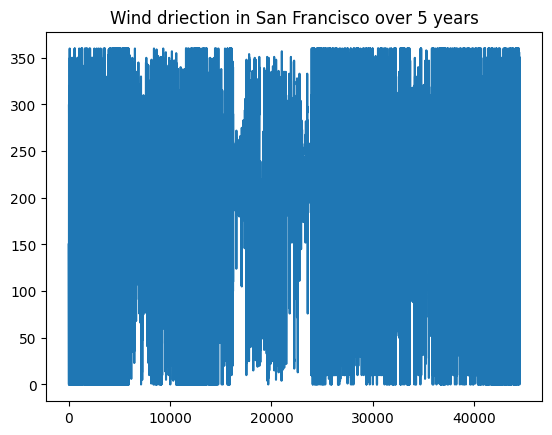

In [ ]:
plt.figure()
plt.plot(df[cityname])
plt.title(f"Wind driection in {cityname} over 5 years")
plt.show()

# one year = 8760 hours

In [ ]:
df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")
df['year'] = df['datetime'].dt.year
df["month"] = df["datetime"].dt.month

#humidity comparison on each year
plt.title(f"Wind Direction Change in {cityname} Over the Years")
sns.lineplot(data = df, x='month', y='San Francisco', hue='year')
plt.show()

NameError: name 'pd' is not defined

# Improving data

## Dew Point

<img src="https://www.linseis.com/wp-content/uploads/2021/05/Relative-Humidity-WV.png">


<img src="https://www.mrfixitbali.com/images/articleimages/dew-point-chart-compact.gif">

In [ ]:
cityname = 'San Francisco'

df_hum = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/humidity.csv", usecols=['datetime', cityname])
df_tem = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/temperature.csv", usecols=['datetime', cityname])

dew_point = []

df_tem = df_tem.rename(columns={"San Francisco": "temperature"})
df_hum = df_hum.rename(columns={"San Francisco": "humidity"})


df_merged = df_tem.merge(df_hum, on='datetime')

df_merged = df_merged.dropna()

print(df_merged)


                  datetime  temperature  humidity
1      2012-10-01 13:00:00   289.480000      88.0
2      2012-10-01 14:00:00   289.474993      87.0
3      2012-10-01 15:00:00   289.460618      86.0
4      2012-10-01 16:00:00   289.446243      85.0
5      2012-10-01 17:00:00   289.431869      84.0
...                    ...          ...       ...
44456  2017-10-27 20:00:00   297.060000      28.0
44457  2017-10-27 21:00:00   299.140000      25.0
44458  2017-10-27 22:00:00   300.560000      22.0
44459  2017-10-27 23:00:00   301.060000      20.0
44460  2017-10-28 00:00:00   302.070000      22.0

[44311 rows x 3 columns]


In [ ]:
def dew_point(row):
  t = row['temperature']
  h = row['humidity']
  return ((h/100)**(0.125)) * (112 + 0.9*t) + 0.1*t -112

In [ ]:
df_merged['dew_point'] = df_merged.apply(dew_point, axis=1)

df_merged.head()

,datetime,temperature,humidity,dew_point
1,2012-10-01 13:00:00,289.480000,88.0,283.574555
2,2012-10-01 14:00:00,289.474993,87.0,283.046242
3,2012-10-01 15:00:00,289.460618,86.0,282.503440
4,2012-10-01 16:00:00,289.446243,85.0,281.955270
5,2012-10-01 17:00:00,289.431869,84.0,281.401610


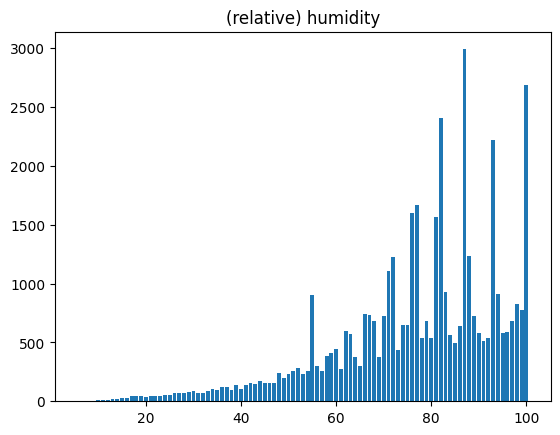

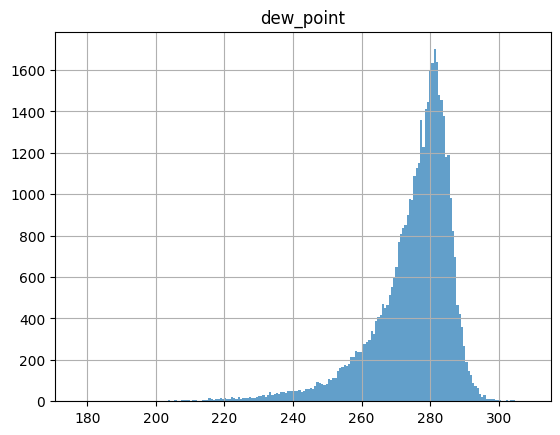

In [ ]:
sf = df_merged['humidity'].value_counts().to_dict()

plt.bar(*zip(*sf.items()))
plt.title('(relative) humidity')
plt.show()

df_merged.hist(bins=200, column=['dew_point'], alpha=0.7, label='dew point')
plt.show()

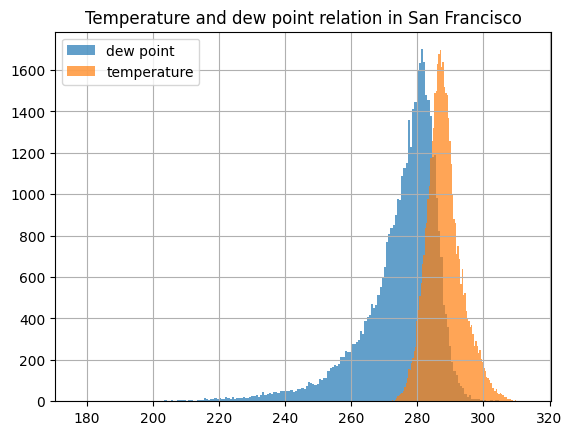

In [ ]:
fig, ax = plt.subplots()

df_merged.hist(bins=200, column=['dew_point'], alpha=0.7, label='dew point', ax=ax)
df_merged.hist(bins=100, column=['temperature'], alpha=0.7, label='temperature', ax=ax)

plt.legend()
plt.title(f"Temperature and dew point relation in {cityname}")
plt.show()

# Data preparation

In [ ]:
x_len = 96
y_len = 24
train_size = 0.8

def dew_point(row):
  t = row['temperature']
  h = row['humidity']
  return ((h/100)**(0.125)) * (112 + 0.9*t) + 0.1*t -112

def row_sine(row):
  wd = row['wind_direction']
  return math.sin(math.radians(wd))

def row_cosine(row):
  wd = row['wind_direction']
  return math.cos(math.radians(wd))


def prepare_city_data(cityname):
  # check if there is a column like cityname

  # reading files
  df_temp = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/temperature.csv",
                        usecols=['datetime', cityname])
  df_pre = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/pressure.csv",
                      usecols=['datetime', cityname])
  df_speed = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/wind_speed.csv",
                        usecols=['datetime', cityname])
  df_dir = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/wind_direction.csv",
                        usecols=['datetime', cityname])
  df_humid = pd.read_csv(r"/content/drive/My Drive/MLA_project/datasets/humidity.csv",
                        usecols=['datetime', cityname])

  # renaming columns (mostly to make it clearer for us)
  df_temp = df_temp.rename(columns={cityname: "temperature"})
  df_pre = df_pre.rename(columns={cityname: "pressure"})
  df_speed = df_speed.rename(columns={cityname: "wind_speed"})
  df_dir = df_dir.rename(columns={cityname: "wind_direction"})
  df_humid = df_humid.rename(columns={cityname: "humidity"})

  # merging columns into one dataframe
  df_merged = df_temp.merge(df_pre, on='datetime')
  df_merged = df_merged.merge(df_speed, on='datetime')
  df_merged = df_merged.merge(df_dir, on='datetime')
  df_merged = df_merged.merge(df_humid, on='datetime')


  # calculating dew point and dropping humidity
  df_merged['dew_point'] = df_merged.apply(dew_point, axis=1)

  df_merged['sine'] = df_merged.apply(row_sine, axis=1)
  df_merged['cosine'] = df_merged.apply(row_cosine, axis=1)

  # df_merged = df_merged.drop(['datetime', 'humidity'], axis=1)

  # filling NaNs with backfill
  data = df_merged.fillna(method='bfill')
  data = data.fillna(method='ffill')#.to_numpy(copy=True)

  return data

def prepare_data(citydata, columns, x_len=96, y_len=24, train_size=0.8):
    # normalizing (todo: maybe return normalization parametres in this function?)
  data = np.squeeze(citydata[columns]).to_numpy(copy=True)
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data =  (data - data_mean) / data_std

  # Prepare X and y sequences
  num_sequences: int = len(data) + 1 - x_len - y_len
  X =[]
  y = []
  for i in range(num_sequences):
    X.append(data[i:(i+x_len)])
    y.append(data[(i+x_len)])


  X = np.array(X)
  y = np.array(y)

  train_len = int(num_sequences * train_size)

  # X_train, X_test, y_train, y_test =  [X[:train_len], X[train_len:], y[:train_len], y[train_len:]]

  # returning prepared data as well as normalization params
  return [X[:train_len], X[train_len:], y[:train_len], y[train_len:]], [data_std, data_mean]



In [ ]:
def lstm_model(x_len, attribute_count):
  model = Sequential()
  model.add(LSTM(50, return_sequences=True,
                 input_shape=(x_len, attribute_count)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(LSTM(50, return_sequences=True))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(LSTM(50, return_sequences=True))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(LSTM(50))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(attribute_count))

  model.compile(optimizer='adam', loss='mse', metrics=['mse'])

  return model

In [ ]:
def restore_data(data, std, mean, one_dim=False):
  data = data.T

  if one_dim:
    return data * std + mean

  for i in range(len(data)):
    data[i] = data[i] * std[i] + mean[i]
  return data


def plot_compare(result, compare, title):
  plt.plot(compare, label='true')
  plt.plot(result, label='predicted')
  plt.title(title)
  plt.legend()
  plt.show()

def sin_cos_to_angle(sn, cs):
  angle2 = math.atan2(sn, cs)  # ALWAYS USE THIS
  angle2 *= 180 / math.pi
  if angle2 < 0: angle2 += 360
  return angle2


def angles_to_direction(sin_arr, cos_arr):
  result = []
  for i in range(len(sin_arr)):
    result.append(sin_cos_to_angle(sin_arr[i], cos_arr[i]))

  return result


# Model learning on all attributes at once

In [ ]:
# usage example
cityname = 'San Francisco'

data_sf = prepare_city_data(cityname)

sf_columns = ["temperature", "pressure", "wind_speed", "dew_point", "sine", "cosine"] # you can specify only one column

[X_train, X_test, y_train, y_test], [sf_std, sf_mean] = prepare_data(data_sf, sf_columns)

In [ ]:
model = lstm_model(x_len, X_train.shape[-1])

history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test, y_test), validation_split=0.2)

Epoch 1/20
1129/1129 [==============================] - 39s 25ms/step - loss: 0.6980 - mse: 0.6980 - val_loss: 0.6469 - val_mse: 0.6469
Epoch 2/20
1129/1129 [==============================] - 27s 24ms/step - loss: 0.4204 - mse: 0.4204 - val_loss: 0.5120 - val_mse: 0.5120
Epoch 3/20
1129/1129 [==============================] - 27s 24ms/step - loss: 0.3700 - mse: 0.3700 - val_loss: 0.4456 - val_mse: 0.4456
Epoch 4/20
1129/1129 [==============================] - 33s 29ms/step - loss: 0.3558 - mse: 0.3558 - val_loss: 0.4658 - val_mse: 0.4658
Epoch 5/20
1129/1129 [==============================] - 27s 24ms/step - loss: 0.3492 - mse: 0.3492 - val_loss: 0.4578 - val_mse: 0.4578
Epoch 6/20
1129/1129 [==============================] - 26s 23ms/step - loss: 0.3433 - mse: 0.3433 - val_loss: 0.4723 - val_mse: 0.4723
Epoch 7/20
1129/1129 [==============================] - 26s 23ms/step - loss: 0.3406 - mse: 0.3406 - val_loss: 0.4433 - val_mse: 0.4433
Epoch 8/20
1129/1129 [==========================

In [ ]:
results = model.predict(X_test[:240])
results = restore_data(results, sf_std, sf_mean)


8/8 [==============================] - 0s 12ms/step


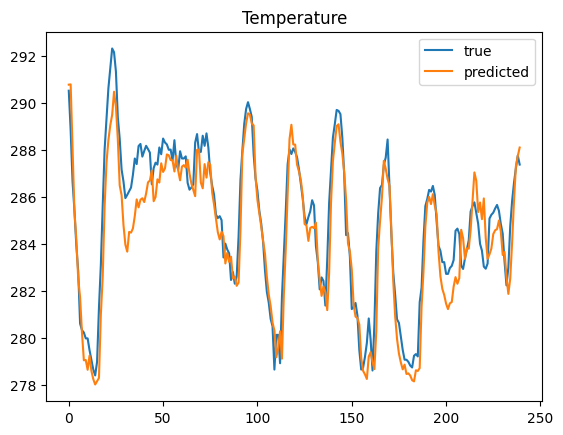

In [ ]:
compare = y_test[:240].copy()
compare = restore_data(compare, sf_std, sf_mean)

plot_compare(results[0], compare[0], "Temperature")


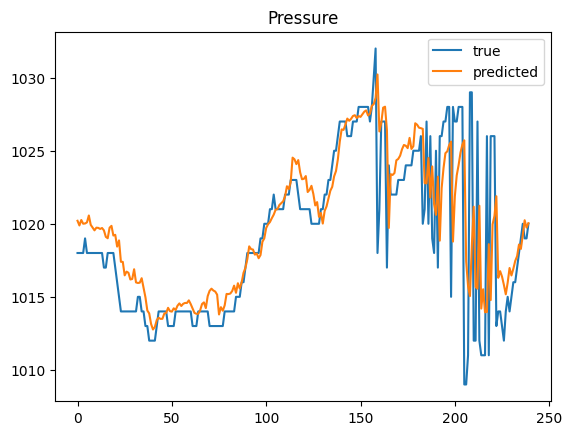

In [ ]:
plot_compare(results[1], compare[1], "Pressure")


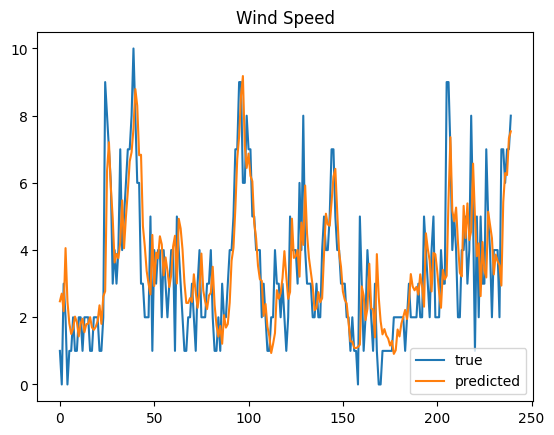

In [ ]:
plot_compare(results[2], compare[2], "Wind Speed")


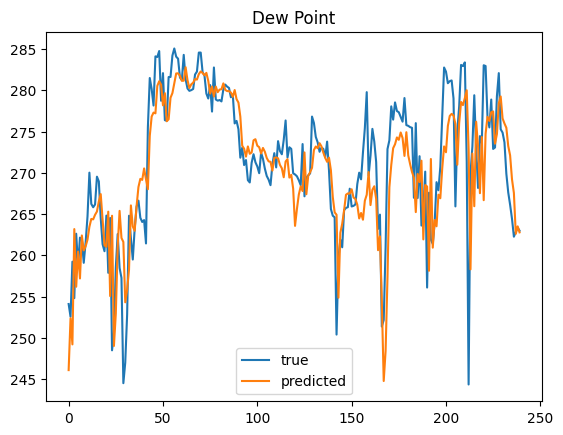

In [ ]:
plot_compare(results[3], compare[3], "Dew Point")


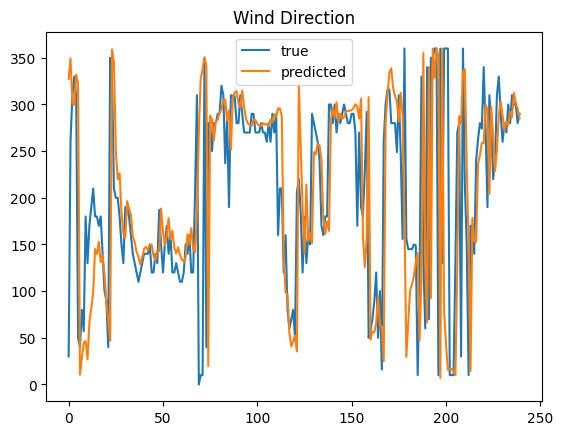

In [ ]:
direction_pred = angles_to_direction(results[4], results[5])
direction_test = angles_to_direction(compare[4], compare[5])

plot_compare(direction_pred, direction_test, "Wind Direction")


In [ ]:
results = model.predict(X_test)

results = results.T
compare = y_test.T
features = ["Temperature", "Pressure", "Wind Speed", "Dew Point", "Sine (direction)", "Cosine (direction)"]
for i in range(len(features)):
    y_test_day = compare[i]
    y_pred_day = results[i]
    rmse = np.sqrt(mean_squared_error(y_test_day, y_pred_day))
    mse = mean_squared_error(y_test_day, y_pred_day)
    mae = mean_absolute_error(y_test_day, y_pred_day)
    r2 = r2_score(y_test_day, y_pred_day)
    pearson, _ = pearsonr(y_test_day, y_pred_day)
    ia = (1 -(np.sum((y_pred_day-y_test_day)**2))/(np.sum((np.abs(y_test_day-np.mean(y_pred_day))+np.abs(y_pred_day-np.mean(y_pred_day)))**2)))
    print(f"{features[i]}: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}, Pearson={pearson:.4f}, IA={ia:.4f}")


283/283 [==============================] - 2s 8ms/step
Temperature: RMSE=0.2380, MSE=0.0566, MAE=0.1833, R^2=0.9617, Pearson=0.9838, IA=0.9899
Pressure: RMSE=0.4200, MSE=0.1764, MAE=0.2820, R^2=0.6781, Pearson=0.8367, IA=0.9024
Wind Speed: RMSE=0.7195, MSE=0.5177, MAE=0.5059, R^2=0.4470, Pearson=0.6728, IA=0.7995
Dew Point: RMSE=0.6691, MSE=0.4477, MAE=0.4252, R^2=0.7356, Pearson=0.8580, IA=0.9205
Sine (direction): RMSE=0.8493, MSE=0.7214, MAE=0.6692, R^2=0.3481, Pearson=0.6086, IA=0.7284
Cosine (direction): RMSE=0.8440, MSE=0.7124, MAE=0.6686, R^2=0.3508, Pearson=0.5980, IA=0.7280


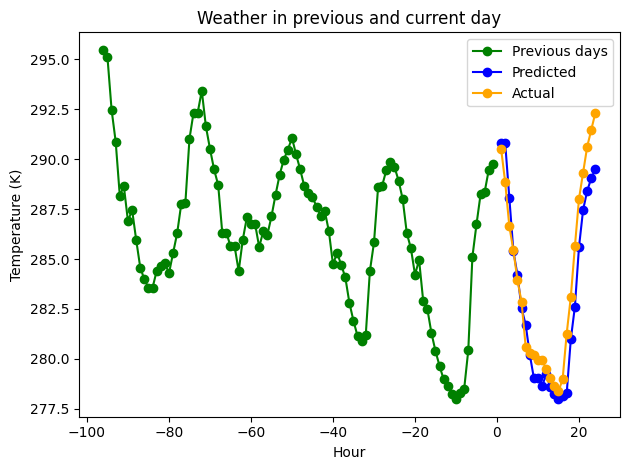

In [ ]:
days = np.arange(1, x_len+y_len+1)
weather_data = np.concatenate((X_test[:, 0, 0][:96], results[0][:24]))
weather_labels = ['Poprzednie dni'] * x_len + ['Przewidywane dni'] * y_len

plt.plot(days[:x_len]-97, weather_data[:x_len]*sf_std[0] + sf_mean[0], color='green', marker='o', label='Previous days')
plt.plot(days[x_len:]-96, weather_data[x_len:]*sf_std[0] + sf_mean[0], color='blue', marker='o', label='Predicted')
plt.plot(days[x_len:]-96, compare[0][:24]*sf_std[0] + sf_mean[0], color='orange', marker='o', label='Actual')
plt.xlabel('Hour')
plt.ylabel('Temperature (K)')
plt.title('Weather in previous and current day')
plt.legend()
plt.tight_layout()
plt.show()

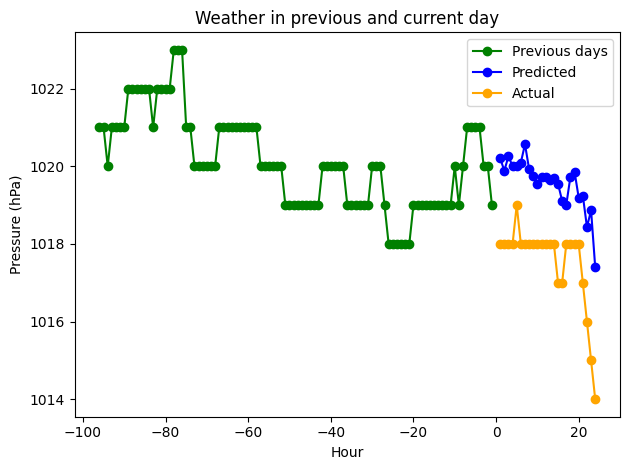

In [ ]:
days = np.arange(1, x_len+y_len+1)
weather_data = np.concatenate((X_test[:, 0, 1][:96], results[1][:24]))
weather_labels = ['Poprzednie dni'] * x_len + ['Przewidywane dni'] * y_len

plt.plot(days[:x_len]-97, weather_data[:x_len]*sf_std[1] + sf_mean[1], color='green', marker='o', label='Previous days')
plt.plot(days[x_len:]-96, weather_data[x_len:]*sf_std[1] + sf_mean[1], color='blue', marker='o', label='Predicted')
plt.plot(days[x_len:]-96, compare[1][:24]*sf_std[1] + sf_mean[1], color='orange', marker='o', label='Actual')
plt.xlabel('Hour')
plt.ylabel('Pressure (hPa)')
plt.title('Weather in previous and current day')
plt.legend()
plt.tight_layout()
plt.show()

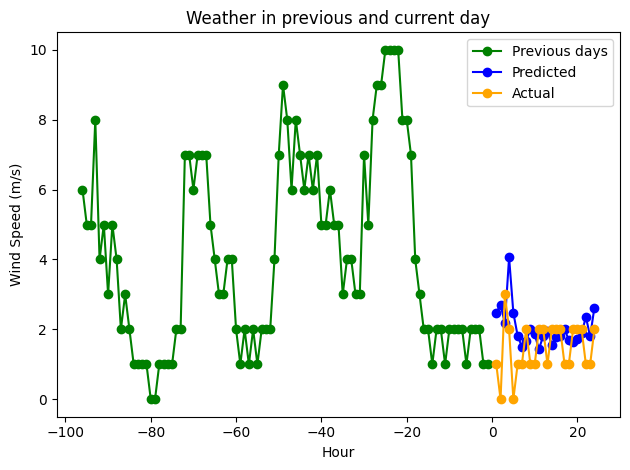

In [ ]:
days = np.arange(1, x_len+y_len+1)
weather_data = np.concatenate((X_test[:, 0, 2][:96], results[2][:24]))
weather_labels = ['Poprzednie dni'] * x_len + ['Przewidywane dni'] * y_len

plt.plot(days[:x_len]-97, weather_data[:x_len]*sf_std[2] + sf_mean[2], color='green', marker='o', label='Previous days')
plt.plot(days[x_len:]-96, weather_data[x_len:]*sf_std[2] + sf_mean[2], color='blue', marker='o', label='Predicted')
plt.plot(days[x_len:]-96, compare[2][:24]*sf_std[2] + sf_mean[2], color='orange', marker='o', label='Actual')
plt.xlabel('Hour')
plt.ylabel('Wind Speed (m/s)')
plt.title('Weather in previous and current day')
plt.legend()
plt.tight_layout()
plt.show()

# Models learning on one attribute at the time (comparison)

## Temperature

In [ ]:
# usage example
cityname = 'San Francisco'
data_sf = prepare_city_data(cityname)


In [ ]:
[X_train, X_test, y_train, y_test], [sf_std, sf_mean] = prepare_data(data_sf, ["temperature"])

model_temp = lstm_model(x_len, 1)

history = model_temp.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test, y_test), validation_split=0.2)

Epoch 1/20
1129/1129 [==============================] - 35s 25ms/step - loss: 0.3133 - mse: 0.3133 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 2/20
1129/1129 [==============================] - 28s 25ms/step - loss: 0.0981 - mse: 0.0981 - val_loss: 0.0826 - val_mse: 0.0826
Epoch 3/20
1129/1129 [==============================] - 27s 24ms/step - loss: 0.0791 - mse: 0.0791 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 4/20
1129/1129 [==============================] - 41s 37ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 5/20
1129/1129 [==============================] - 36s 32ms/step - loss: 0.0725 - mse: 0.0725 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 6/20
1129/1129 [==============================] - 32s 29ms/step - loss: 0.0743 - mse: 0.0743 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 7/20
1129/1129 [==============================] - 32s 28ms/step - loss: 0.0685 - mse: 0.0685 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 8/20
1129/1129 [==========================

8/8 [==============================] - 1s 11ms/step


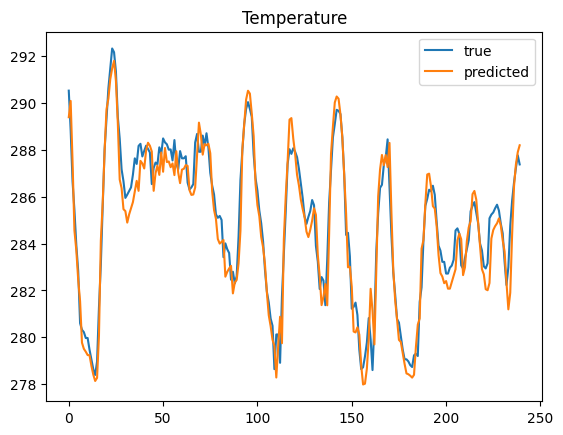

In [ ]:
results = model_temp.predict(X_test[:240])
results = restore_data(results, [sf_std], [sf_mean], one_dim=True)

compare = y_test[:240].copy()
compare = restore_data(compare, [sf_std], [sf_mean], one_dim=True)

plot_compare(results[0], compare, "Temperature")


In [ ]:
def metrics(y_test_day, y_pred_day, attribute_name):
  rmse = np.sqrt(mean_squared_error(y_test_day, y_pred_day))
  mse = mean_squared_error(y_test_day, y_pred_day)
  mae = mean_absolute_error(y_test_day, y_pred_day)
  r2 = r2_score(y_test_day, y_pred_day)
  pearson, _ = pearsonr(y_test_day, y_pred_day)
  ia = (1 -(np.sum((y_pred_day-y_test_day)**2))/(np.sum((np.abs(y_test_day-np.mean(y_pred_day))+np.abs(y_pred_day-np.mean(y_pred_day)))**2)))
  print(f"{attribute_name} : RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}, Pearson={pearson:.4f}, IA={ia:.4f}")


In [ ]:
results = model_temp.predict(X_test)

results = results.T
compare = y_test.T

y_test_day = compare
y_pred_day = results[0]

metrics(y_test_day, y_pred_day, "Temperature")

283/283 [==============================] - 3s 10ms/step
Temperature : RMSE=0.2030, MSE=0.0412, MAE=0.1166, R^2=0.9722, Pearson=0.9884, IA=0.9934


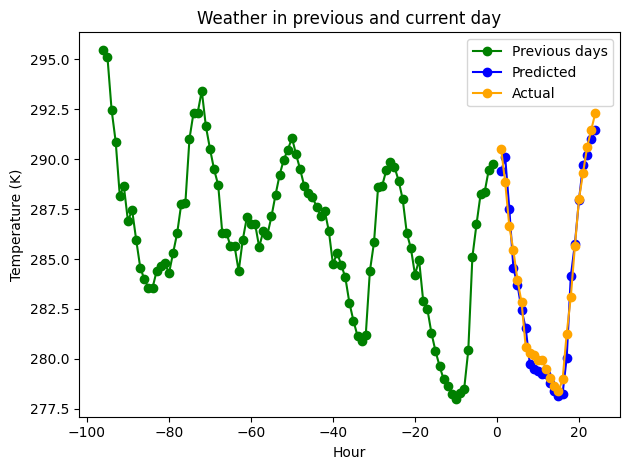

In [ ]:
days = np.arange(1, x_len+y_len+1)
weather_data = np.concatenate((X_test[:, 0][:96], results[0][:24]))
weather_labels = ['Poprzednie dni'] * x_len + ['Przewidywane dni'] * y_len

plt.plot(days[:x_len]-97, weather_data[:x_len]*sf_std + sf_mean, color='green', marker='o', label='Previous days')
plt.plot(days[x_len:]-96, weather_data[x_len:]*sf_std + sf_mean, color='blue', marker='o', label='Predicted')
plt.plot(days[x_len:]-96, compare[:24]*sf_std + sf_mean, color='orange', marker='o', label='Actual')
plt.xlabel('Hour')
plt.ylabel('Temperature (K)')
plt.title('Weather in previous and current day')
plt.legend()
plt.tight_layout()
plt.show()

## Pressure

In [ ]:
[X_train, X_test, y_train, y_test], [sf_std, sf_mean] = prepare_data(data_sf, ["pressure"])

model_pres = lstm_model(x_len, 1)

history = model_pres.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test, y_test), validation_split=0.2)

Epoch 1/20
1129/1129 [==============================] - 295s 253ms/step - loss: 0.3711 - mse: 0.3711 - val_loss: 0.1744 - val_mse: 0.1744
Epoch 2/20
1129/1129 [==============================] - 269s 239ms/step - loss: 0.1839 - mse: 0.1839 - val_loss: 0.1560 - val_mse: 0.1560
Epoch 3/20
1129/1129 [==============================] - 261s 231ms/step - loss: 0.1684 - mse: 0.1684 - val_loss: 0.1550 - val_mse: 0.1550
Epoch 4/20
1129/1129 [==============================] - 267s 236ms/step - loss: 0.1618 - mse: 0.1618 - val_loss: 0.1530 - val_mse: 0.1530
Epoch 5/20
1129/1129 [==============================] - 267s 236ms/step - loss: 0.1566 - mse: 0.1566 - val_loss: 0.1869 - val_mse: 0.1869
Epoch 6/20
1129/1129 [==============================] - 270s 239ms/step - loss: 0.1547 - mse: 0.1547 - val_loss: 0.1605 - val_mse: 0.1605
Epoch 7/20
1129/1129 [==============================] - 264s 234ms/step - loss: 0.1544 - mse: 0.1544 - val_loss: 0.1573 - val_mse: 0.1573
Epoch 8/20
1129/1129 [============

8/8 [==============================] - 5s 76ms/step


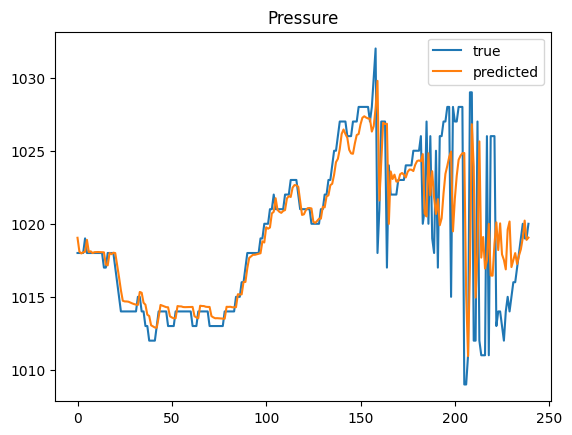

In [ ]:
results = model_pres.predict(X_test[:240])
results = restore_data(results, [sf_std], [sf_mean], one_dim=True)

compare = y_test[:240].copy()
compare = restore_data(compare, [sf_std], [sf_mean], one_dim=True)

plot_compare(results[0], compare, "Pressure")

In [ ]:
results = model_pres.predict(X_test)

results = results.T
compare = y_test.T

y_test_day = compare
y_pred_day = results[0]

metrics(y_test_day, y_pred_day, "Pressure")

283/283 [==============================] - 20s 71ms/step
Pressure : RMSE=0.3960, MSE=0.1568, MAE=0.2346, R^2=0.7138, Pearson=0.8474, IA=0.9102


## Wind Speed

In [ ]:
[X_train, X_test, y_train, y_test], [sf_std, sf_mean] = prepare_data(data_sf, ["wind_speed"])

model_ws = lstm_model(x_len, 1)

history = model_ws.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test, y_test), validation_split=0.2)

Epoch 1/10
1129/1129 [==============================] - 273s 230ms/step - loss: 0.7096 - mse: 0.7096 - val_loss: 0.5178 - val_mse: 0.5178
Epoch 2/10
1129/1129 [==============================] - 248s 220ms/step - loss: 0.4550 - mse: 0.4550 - val_loss: 0.5222 - val_mse: 0.5222
Epoch 3/10
1129/1129 [==============================] - 251s 222ms/step - loss: 0.4406 - mse: 0.4406 - val_loss: 0.5471 - val_mse: 0.5471
Epoch 4/10
1129/1129 [==============================] - 248s 220ms/step - loss: 0.4271 - mse: 0.4271 - val_loss: 0.5162 - val_mse: 0.5162
Epoch 5/10
1129/1129 [==============================] - 272s 241ms/step - loss: 0.4279 - mse: 0.4279 - val_loss: 0.5253 - val_mse: 0.5253
Epoch 6/10
1129/1129 [==============================] - 286s 253ms/step - loss: 0.4224 - mse: 0.4224 - val_loss: 0.5265 - val_mse: 0.5265
Epoch 7/10
1129/1129 [==============================] - 278s 246ms/step - loss: 0.4171 - mse: 0.4171 - val_loss: 0.5079 - val_mse: 0.5079
Epoch 8/10
1129/1129 [============

8/8 [==============================] - 2s 43ms/step


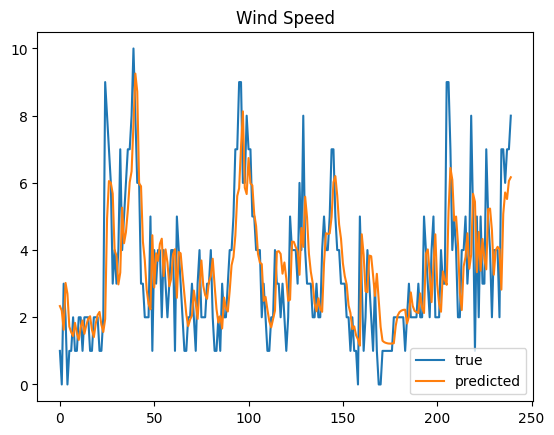

In [ ]:
results = model_ws.predict(X_test[:240])
results = restore_data(results, [sf_std], [sf_mean], one_dim=True)

compare = y_test[:240].copy()
compare = restore_data(compare, [sf_std], [sf_mean], one_dim=True)

plot_compare(results[0], compare, "Wind Speed")

In [ ]:
results = model_ws.predict(X_test)

results = results.T
compare = y_test.T

y_test_day = compare
y_pred_day = results[0]

metrics(y_test_day, y_pred_day, "Wind Speed")

283/283 [==============================] - 17s 60ms/step
Wind Speed : RMSE=0.7080, MSE=0.5013, MAE=0.4965, R^2=0.4645, Pearson=0.6847, IA=0.8046


## Dew Point

In [ ]:
[X_train, X_test, y_train, y_test], [sf_std, sf_mean] = prepare_data(data_sf, ["dew_point"])

model_dp = lstm_model(x_len, 1)

history = model_dp.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test, y_test), validation_split=0.2)

Epoch 1/10
1129/1129 [==============================] - 269s 230ms/step - loss: 0.5956 - mse: 0.5956 - val_loss: 0.4400 - val_mse: 0.4400
Epoch 2/10
1129/1129 [==============================] - 259s 229ms/step - loss: 0.3494 - mse: 0.3494 - val_loss: 0.4281 - val_mse: 0.4281
Epoch 3/10
1129/1129 [==============================] - 260s 231ms/step - loss: 0.3290 - mse: 0.3290 - val_loss: 0.5140 - val_mse: 0.5140
Epoch 4/10
1129/1129 [==============================] - 267s 236ms/step - loss: 0.3211 - mse: 0.3211 - val_loss: 0.4165 - val_mse: 0.4165
Epoch 5/10
1129/1129 [==============================] - 269s 238ms/step - loss: 0.3116 - mse: 0.3116 - val_loss: 0.4085 - val_mse: 0.4085
Epoch 6/10
1129/1129 [==============================] - 270s 239ms/step - loss: 0.3102 - mse: 0.3102 - val_loss: 0.4789 - val_mse: 0.4789
Epoch 7/10
1129/1129 [==============================] - 263s 233ms/step - loss: 0.3082 - mse: 0.3082 - val_loss: 0.4050 - val_mse: 0.4050
Epoch 8/10
1129/1129 [============

8/8 [==============================] - 2s 52ms/step


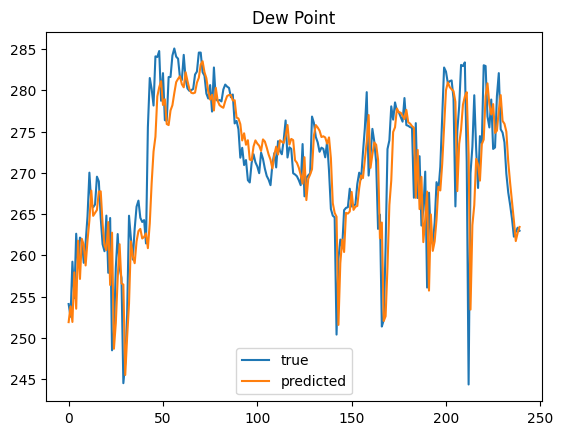

In [ ]:
results = model_dp.predict(X_test[:240])
results = restore_data(results, [sf_std], [sf_mean], one_dim=True)

compare = y_test[:240].copy()
compare = restore_data(compare, [sf_std], [sf_mean], one_dim=True)

plot_compare(results[0], compare, "Dew Point")

In [ ]:
results = model_dp.predict(X_test)

results = results.T
compare = y_test.T

y_test_day = compare
y_pred_day = results[0]

metrics(y_test_day, y_pred_day, "Dew Point")

283/283 [==============================] - 15s 54ms/step
Dew Point : RMSE=0.6328, MSE=0.4004, MAE=0.4193, R^2=0.7635, Pearson=0.8743, IA=0.9295


# Creating model for Toronto and using it on Tel Awiw

In [ ]:
cityname = 'Toronto'

data_tor = prepare_city_data(cityname)

tor_columns = ["temperature", "pressure", "wind_speed", "dew_point", "sine", "cosine"]

[X_train, X_test, y_train, y_test], [tor_std, tor_mean] = prepare_data(data_tor, tor_columns)

In [ ]:
model = lstm_model(x_len, X_train.shape[-1])

history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test, y_test), validation_split=0.2)

Epoch 1/20
1129/1129 [==============================] - 39s 27ms/step - loss: 0.5594 - mse: 0.5594 - val_loss: 0.2907 - val_mse: 0.2907
Epoch 2/20
1129/1129 [==============================] - 31s 28ms/step - loss: 0.3158 - mse: 0.3158 - val_loss: 0.2360 - val_mse: 0.2360
Epoch 3/20
1129/1129 [==============================] - 35s 31ms/step - loss: 0.2802 - mse: 0.2802 - val_loss: 0.2192 - val_mse: 0.2192
Epoch 4/20
1129/1129 [==============================] - 32s 29ms/step - loss: 0.2676 - mse: 0.2676 - val_loss: 0.2215 - val_mse: 0.2215
Epoch 5/20
1129/1129 [==============================] - 30s 26ms/step - loss: 0.2634 - mse: 0.2634 - val_loss: 0.2203 - val_mse: 0.2203
Epoch 6/20
1129/1129 [==============================] - 29s 25ms/step - loss: 0.2590 - mse: 0.2590 - val_loss: 0.2192 - val_mse: 0.2192
Epoch 7/20
1129/1129 [==============================] - 29s 25ms/step - loss: 0.2567 - mse: 0.2567 - val_loss: 0.2144 - val_mse: 0.2144
Epoch 8/20
1129/1129 [==========================

In [ ]:
results = model.predict(X_test[:240])
results = restore_data(results, tor_std, tor_mean)

8/8 [==============================] - 0s 21ms/step


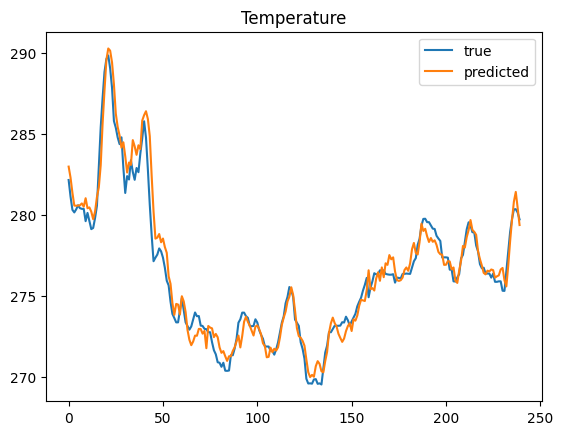

In [ ]:
compare = y_test[:240].copy()
compare = restore_data(compare, tor_std, tor_mean)

plot_compare(results[0], compare[0], "Temperature")

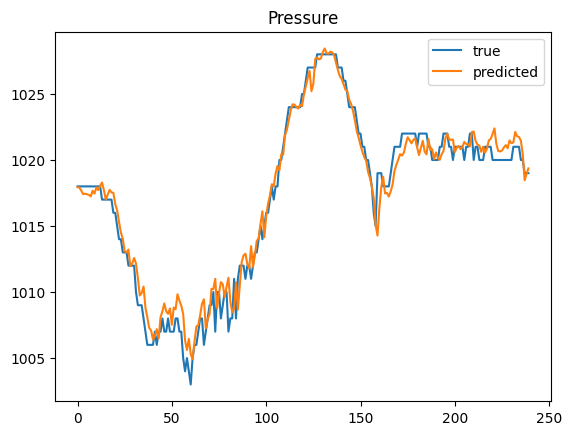

In [ ]:
plot_compare(results[1], compare[1], "Pressure")


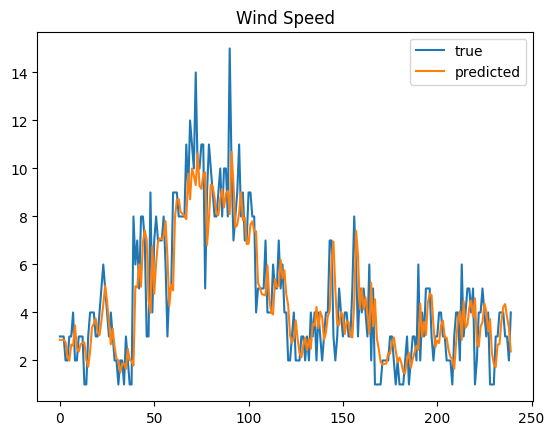

In [ ]:
plot_compare(results[2], compare[2], "Wind Speed")


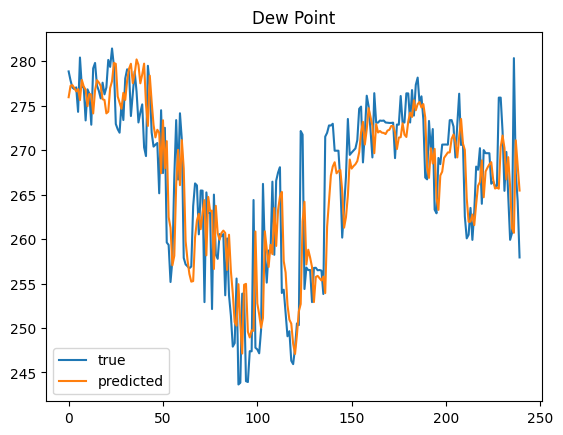

In [ ]:
plot_compare(results[3], compare[3], "Dew Point")


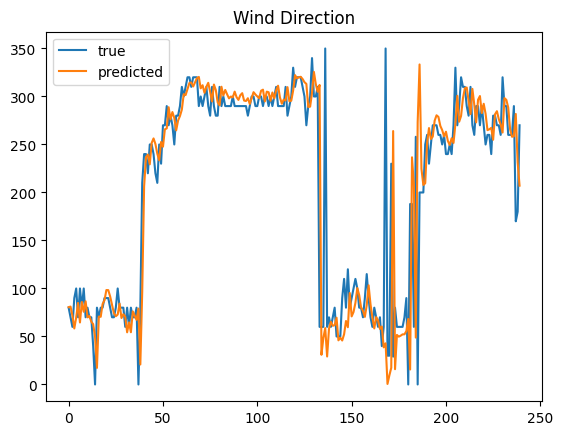

In [ ]:
direction_pred = angles_to_direction(results[4], results[5])
direction_test = angles_to_direction(compare[4], compare[5])

plot_compare(direction_pred, direction_test, "Wind Direction")

In [ ]:
results = model.predict(X_test)

results = results.T
compare = y_test.T
features = ["Temperature", "Pressure", "Wind Speed", "Dew Point", "Sine (direction)", "Cosine (direction)"]
for i in range(len(features)):
    y_test_day = compare[i]
    y_pred_day = results[i]
    rmse = np.sqrt(mean_squared_error(y_test_day, y_pred_day))
    mse = mean_squared_error(y_test_day, y_pred_day)
    mae = mean_absolute_error(y_test_day, y_pred_day)
    r2 = r2_score(y_test_day, y_pred_day)
    pearson, _ = pearsonr(y_test_day, y_pred_day)
    ia = (1 -(np.sum((y_pred_day-y_test_day)**2))/(np.sum((np.abs(y_test_day-np.mean(y_pred_day))+np.abs(y_pred_day-np.mean(y_pred_day)))**2)))
    print(f"{features[i]}: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}, Pearson={pearson:.4f}, IA={ia:.4f}")

283/283 [==============================] - 4s 14ms/step
Temperature: RMSE=0.1140, MSE=0.0130, MAE=0.0893, R^2=0.9848, Pearson=0.9932, IA=0.9963
Pressure: RMSE=0.1297, MSE=0.0168, MAE=0.0944, R^2=0.9762, Pearson=0.9881, IA=0.9939
Wind Speed: RMSE=0.6304, MSE=0.3974, MAE=0.4613, R^2=0.6153, Pearson=0.7875, IA=0.8791
Dew Point: RMSE=0.3740, MSE=0.1398, MAE=0.2639, R^2=0.8631, Pearson=0.9297, IA=0.9623
Sine (direction): RMSE=0.4832, MSE=0.2335, MAE=0.3360, R^2=0.7789, Pearson=0.8839, IA=0.9321
Cosine (direction): RMSE=0.6813, MSE=0.4641, MAE=0.4845, R^2=0.5106, Pearson=0.7170, IA=0.8285


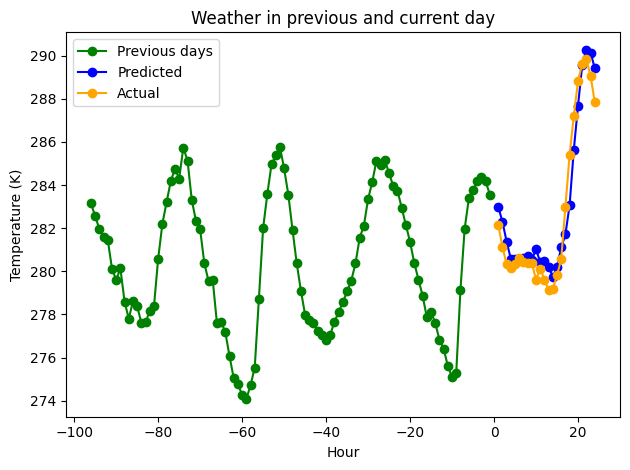

In [ ]:
days = np.arange(1, x_len+y_len+1)
weather_data = np.concatenate((X_test[:, 0, 0][:96], results[0][:24]))
weather_labels = ['Poprzednie dni'] * x_len + ['Przewidywane dni'] * y_len

plt.plot(days[:x_len]-97, weather_data[:x_len]*tor_std[0] + tor_mean[0], color='green', marker='o', label='Previous days')
plt.plot(days[x_len:]-96, weather_data[x_len:]*tor_std[0] + tor_mean[0], color='blue', marker='o', label='Predicted')
plt.plot(days[x_len:]-96, compare[0][:24]*tor_std[0] + tor_mean[0], color='orange', marker='o', label='Actual')
plt.xlabel('Hour')
plt.ylabel('Temperature (K)')
plt.title('Weather in previous and current day')
plt.legend()
plt.tight_layout()
plt.show()

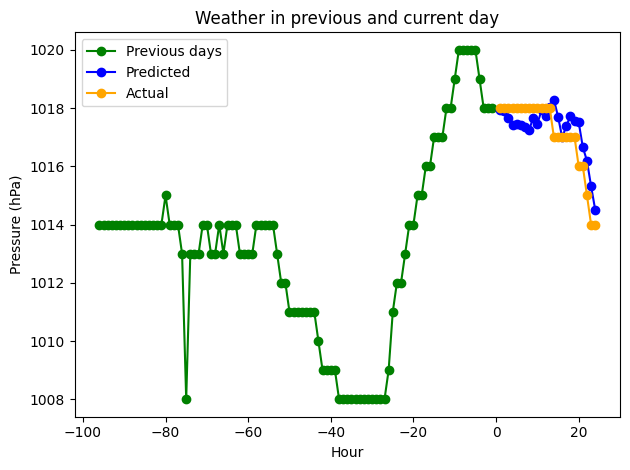

In [ ]:
days = np.arange(1, x_len+y_len+1)
weather_data = np.concatenate((X_test[:, 0, 1][:96], results[1][:24]))
weather_labels = ['Poprzednie dni'] * x_len + ['Przewidywane dni'] * y_len

plt.plot(days[:x_len]-97, weather_data[:x_len]*tor_std[1] + tor_mean[1], color='green', marker='o', label='Previous days')
plt.plot(days[x_len:]-96, weather_data[x_len:]*tor_std[1] + tor_mean[1], color='blue', marker='o', label='Predicted')
plt.plot(days[x_len:]-96, compare[1][:24]*tor_std[1] + tor_mean[1], color='orange', marker='o', label='Actual')
plt.xlabel('Hour')
plt.ylabel('Pressure (hPa)')
plt.title('Weather in previous and current day')
plt.legend()
plt.tight_layout()
plt.show()

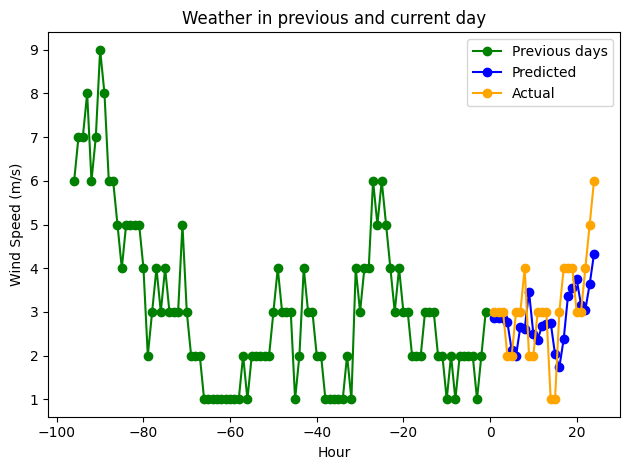

In [ ]:
days = np.arange(1, x_len+y_len+1)
weather_data = np.concatenate((X_test[:, 0, 2][:96], results[2][:24]))
weather_labels = ['Poprzednie dni'] * x_len + ['Przewidywane dni'] * y_len

plt.plot(days[:x_len]-97, weather_data[:x_len]*tor_std[2] + tor_mean[2], color='green', marker='o', label='Previous days')
plt.plot(days[x_len:]-96, weather_data[x_len:]*tor_std[2] + tor_mean[2], color='blue', marker='o', label='Predicted')
plt.plot(days[x_len:]-96, compare[2][:24]*tor_std[2] + tor_mean[2], color='orange', marker='o', label='Actual')
plt.xlabel('Hour')
plt.ylabel('Wind Speed (m/s)')
plt.title('Weather in previous and current day')
plt.legend()
plt.tight_layout()
plt.show()

## Using Toronto model on Tel Aviv

In [ ]:
cityname = 'Tel Aviv District'

data_ta = prepare_city_data(cityname)

ta_columns = ["temperature", "pressure", "wind_speed", "dew_point", "sine", "cosine"]

[X_train, X_test, y_train, y_test], [ta_std, ta_mean] = prepare_data(data_ta, ta_columns)

8/8 [==============================] - 0s 15ms/step


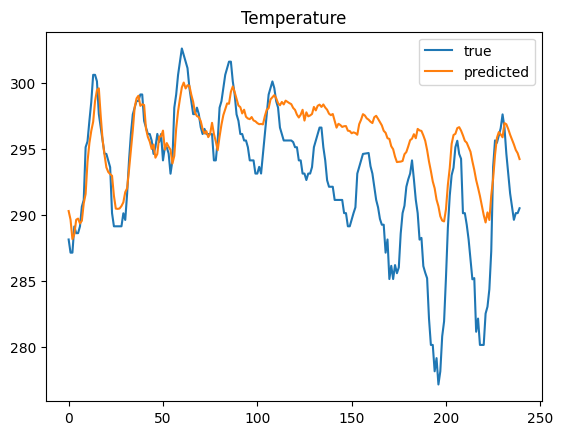

In [ ]:
results = model.predict(X_test[:240])
results = restore_data(results, ta_std, ta_mean)

compare = y_test[:240].copy()
compare = restore_data(compare, ta_std, ta_mean)

plot_compare(results[0], compare[0], "Temperature")

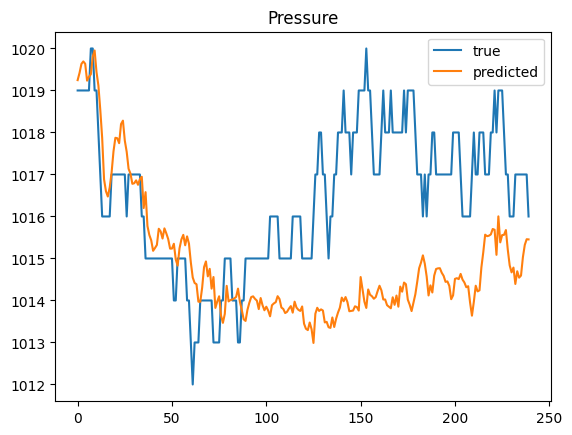

In [ ]:
plot_compare(results[1], compare[1], "Pressure")

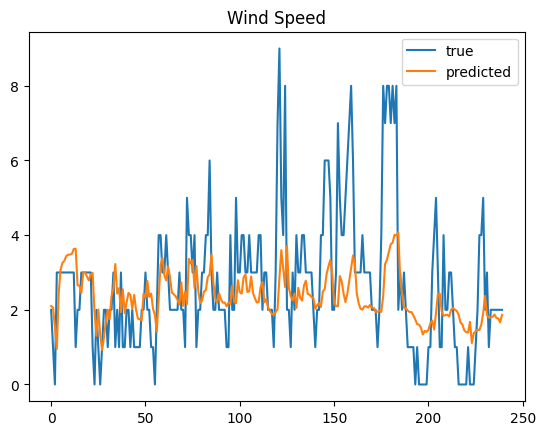

In [ ]:
plot_compare(results[2], compare[2], "Wind Speed")

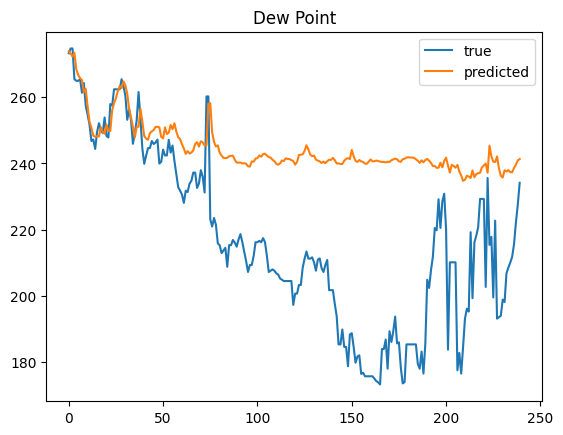

In [ ]:
plot_compare(results[3], compare[3], "Dew Point")

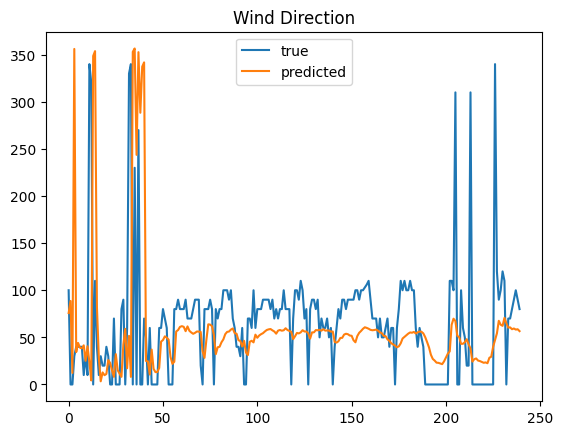

In [ ]:
direction_pred = angles_to_direction(results[4], results[5])
direction_test = angles_to_direction(compare[4], compare[5])

plot_compare(direction_pred, direction_test, "Wind Direction")

In [ ]:
results = model.predict(X_test)

results = results.T
compare = y_test.T
features = ["Temperature", "Pressure", "Wind Speed", "Dew Point", "Sine (direction)", "Cosine (direction)"]
for i in range(len(features)):
    y_test_day = compare[i]
    y_pred_day = results[i]
    rmse = np.sqrt(mean_squared_error(y_test_day, y_pred_day))
    mse = mean_squared_error(y_test_day, y_pred_day)
    mae = mean_absolute_error(y_test_day, y_pred_day)
    r2 = r2_score(y_test_day, y_pred_day)
    pearson, _ = pearsonr(y_test_day, y_pred_day)
    ia = (1 -(np.sum((y_pred_day-y_test_day)**2))/(np.sum((np.abs(y_test_day-np.mean(y_pred_day))+np.abs(y_pred_day-np.mean(y_pred_day)))**2)))
    print(f"{features[i]}: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}, Pearson={pearson:.4f}, IA={ia:.4f}")

283/283 [==============================] - 4s 12ms/step
Temperature: RMSE=0.2639, MSE=0.0696, MAE=0.1787, R^2=0.9269, Pearson=0.9734, IA=0.9796
Pressure: RMSE=0.1888, MSE=0.0357, MAE=0.1268, R^2=0.9417, Pearson=0.9711, IA=0.9843
Wind Speed: RMSE=0.6849, MSE=0.4691, MAE=0.4350, R^2=0.5623, Pearson=0.7562, IA=0.8351
Dew Point: RMSE=0.6339, MSE=0.4019, MAE=0.3490, R^2=0.7085, Pearson=0.8578, IA=0.8942
Sine (direction): RMSE=0.6805, MSE=0.4631, MAE=0.5109, R^2=0.4280, Pearson=0.6591, IA=0.7733
Cosine (direction): RMSE=0.7687, MSE=0.5909, MAE=0.5464, R^2=0.3841, Pearson=0.6229, IA=0.7606
